In [1]:
import MetaTrader5 as mt5
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelextrema
import numpy as np

# Define the forex pair and timeframe
symbol = "XAUUSD"
timeframe = mt5.TIMEFRAME_M30 

# Define the start and end times for the data
start_time = pd.to_datetime('2024-01-01 00:00:00')  # Replace with a valid start date
end_time = pd.to_datetime('2024-01-05 23:59:59')  # Replace with a valid end date


def get_historical_data(symbol, timeframe, start_time, end_time):
    """Retrieves historical data from the MT5 terminal and saves it to a CSV file.

    Args:
        symbol (str): The forex pair to retrieve data for.
        timeframe (int): The timeframe to retrieve data in. Must be one of the
            TIMEFRAME_* constants from the MetaTrader5 module.
        start_time (datetime): The starting date and time for the data retrieval.
        end_time (datetime): The ending date and time for the data retrieval.
    """

    # Initialize MT5 connection
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        quit()

    # Retrieve historical data
    rates = mt5.copy_rates_range(symbol, timeframe, start_time, end_time)

    # Check if data was retrieved successfully
    if rates is None:
        print("No data retrieved, error code =", mt5.last_error())
        mt5.shutdown()  # Shutdown the connection
        quit()

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')  # Convert timestamp to datetime

    # Save the data to a CSV file
    df.to_csv('forex_data_ex.csv', index=False)

    # Close the connection to MetaTrader5
    mt5.shutdown()


# get_historical_data(symbol, timeframe, start_time, end_time)





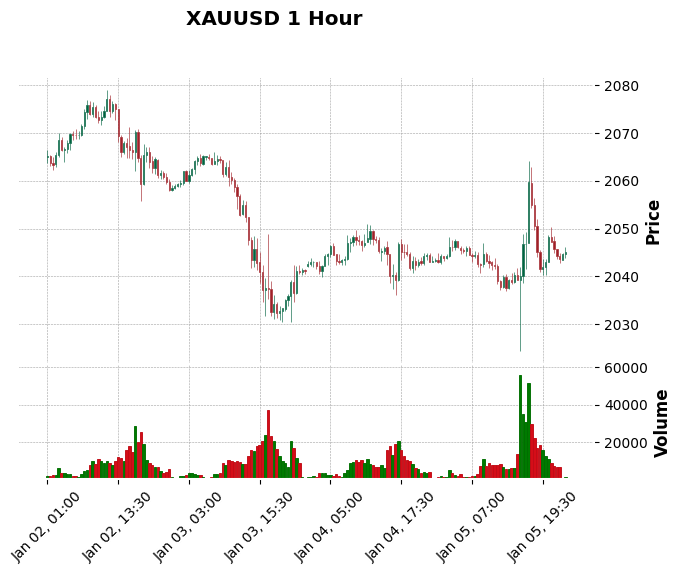

In [2]:
"""
Plot the {symbol} 1 hour candlestick chart using mplfinance.

This script loads the data from a CSV file, converts the 'time'
column to a datetime and sets it as the index. It then converts
the DataFrame to the format expected by mplfinance and plots the
candlestick chart using the 'charles' style.
"""
def prepData(visualize=False):
    # Load the data from the CSV file
    df = pd.read_csv('forex_data_ex.csv')

    # Convert the 'time' column to datetime if it's not already
    df['time'] = pd.to_datetime(df['time'])

    # Set the 'time' column as the index
    df.set_index('time', inplace=True)

    # Convert the DataFrame to the format expected by mplfinance
    ohlcv_data = df[['open', 'high', 'low', 'close', 'tick_volume']]

    # Rename the columns to the format expected by mplfinance
    ohlcv_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    if visualize:
        # Plot the candlestick chart
        mpf.plot(ohlcv_data, type='candle',
                style='charles',
                title=f'{symbol} 1 Hour',
                volume=True)
        return ohlcv_data
    else:
        return ohlcv_data
    

df = prepData(visualize=True)



In [3]:
# Assuming df is your DataFrame and 'Close' is the column with the closing prices
def cleanData(visualize=False) -> None:
    window_length = 10
    polyorder = 5

    # Apply the Savitzky-Golay filter to the 'Close' prices
    smoothed_close = savgol_filter(df['Close'], window_length, polyorder)

    df['smoothed_close'] = smoothed_close

    if visualize:
        # Plot original data
        plt.plot(df.index, df['Close'], label='Close Price')

        # # Plot smoothed data
        plt.plot(df.index, df["smoothed_close"], label='Smoothed Close Price')

cleanData()

C:\Users\Adewu\AppData\Local\Temp\ipykernel_12812\1556639392.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['Is_High'] = df["High"][highs[0]]
C:\Users\Adewu\AppData\Local\Temp\ipykernel_12812\1556639392.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['Is_Low'] =  df["Low"][lows[0]]


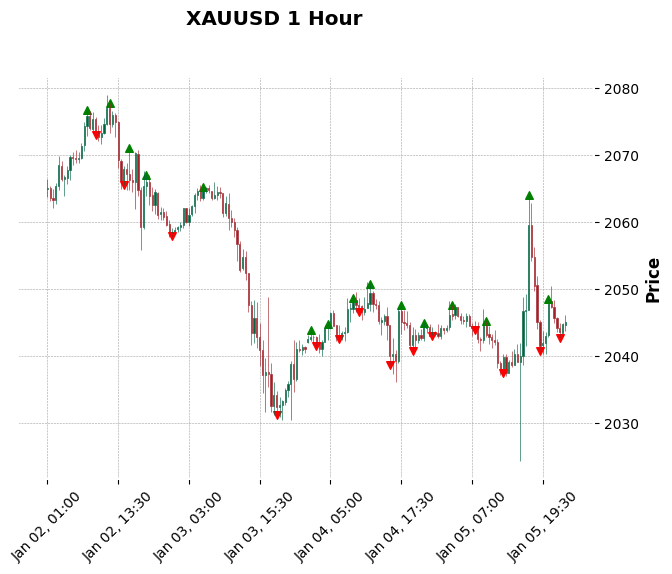

In [4]:

def detectPivotPoints(visualize=False):
    # Detect highs and lows
    highs = argrelextrema(df["smoothed_close"].to_numpy(), np.greater, mode='wrap', order=3)
    lows = argrelextrema(df["smoothed_close"].to_numpy(), np.less, mode='wrap', order=3)


    df['Is_High'] = df["High"][highs[0]]
    df['Is_Low'] =  df["Low"][lows[0]]

    df.fillna(0)


    if visualize:
        apd = [
            mpf.make_addplot(df['Is_High'], scatter=True, markersize=30, marker='^', color='g'),
            mpf.make_addplot(df['Is_Low'], scatter=True, markersize=30, marker='v', color='r')
        ]

        mpf.plot(df, type='candle',
            addplot=apd,
            style='charles',
            title=f'{symbol} 1 Hour')

detectPivotPoints(visualize=True)


In [5]:
# df['SMA_4'] = df['demand'].rolling(window=4).mean()



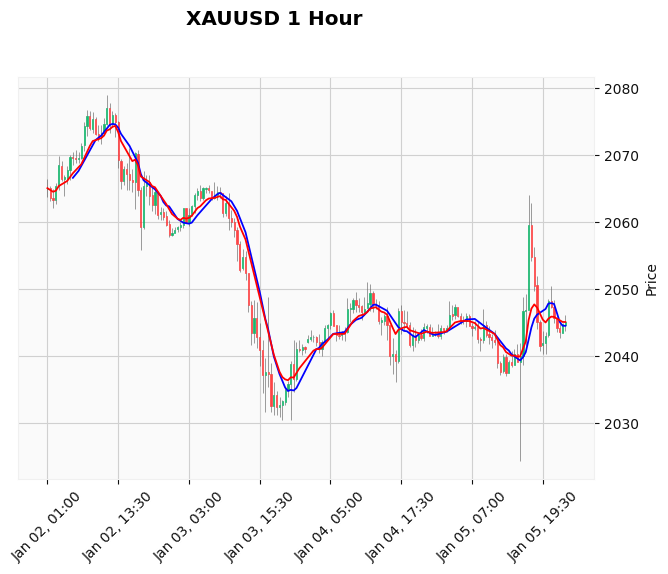

                        Open     High      Low    Close  Volume  \
time                                                              
2024-01-02 01:00:00  2064.98  2066.54  2063.82  2065.11    1921   
2024-01-02 01:30:00  2065.11  2065.48  2063.14  2063.66    2164   
2024-01-02 02:00:00  2063.68  2064.99  2062.17  2063.30    2484   
2024-01-02 02:30:00  2063.41  2065.94  2062.80  2065.45    2349   
2024-01-02 03:00:00  2065.43  2069.97  2064.88  2068.52    6027   
...                      ...      ...      ...      ...     ...   
2024-01-05 21:30:00  2047.34  2048.43  2044.93  2045.70    7385   
2024-01-05 22:00:00  2045.71  2045.84  2043.67  2044.18    6854   
2024-01-05 22:30:00  2044.20  2044.97  2042.76  2043.59    6848   
2024-01-05 23:00:00  2043.53  2044.92  2043.53  2044.75    1126   
2024-01-05 23:30:00  2044.64  2046.15  2043.81  2045.06    1199   

                     smoothed_close  Is_High   Is_Low       SMA          EMA  
time                                             

In [6]:
# def detectCHOCH():
#     # df.fillna(0)
#     # Create a new column 'Is_Lower_Low' to check if the current low is lower than the previous low
#     df["previous_low"] = df['Is_Low'].dropna().iloc[-1]
#     df["lowCondition"] = df["previous_low"] > df['Is_Low']
#     df['bearishCC'] = np.where(df["lowCondition"], df['Is_Low'], np.nan)

#     # Create a new column 'Is_Higher_High' to check if the current high is higher than the previous high
#     # previous_high = df['Is_High'].dropna().iloc[-1]
#     # highCondition =previous_high < df['Is_High']
#     # df['bullishCC'] = np.where(highCondition, df['Is_High'], np.nan)

#     apd = [
#             # mpf.make_addplot(df['bullishCC'], scatter=True, markersize=30, marker='^', color='b'),
#             mpf.make_addplot(df['bearishCC'], scatter=True, markersize=30, marker='v', color='y')
#         ]

df['SMA'] = df['Close'].rolling(window=10).mean()
df['EMA'] = df['Close'].ewm(span=10, adjust=False).mean()

apd = [mpf.make_addplot(df['SMA'], linestyle="-", color='b'),
        mpf.make_addplot(df['EMA'], linestyle="-", color='r')]

# start_time = '2024-01-01 00:00:00'
# start_time = '2024-01-02 23:59:59'
# sliced_df = df.loc[start_time:end_time]

mpf.plot(df, type='candle',
    addplot=apd,
    style='yahoo',
    title=f'{symbol} 1 Hour')

print(df)



# detectCHOCH()


In [9]:
# print(df)
plot_data = []
index_low = []
index_high = []
occurences = []
entries = []
stop_losses = []
take_profits = []
fibonacci_levels = [0, 0.272, 0.382, 0.5, 0.618, 0.786, 1, 1.361,1.836]
for x in range(df.shape[0]):
    # print(df.iloc[x,0])
    # print(df.iloc[x,1])

    if (df.iloc[x-0,2] == 'low' and df.iloc[x-1,2] == 'high' and df.iloc[x-2,2] == 'low' and df.iloc[x-3,2] == 'high' and df.iloc[x-4,2] == 'low' and df.iloc[x-5,2] == 'high') and (df.iloc[x-0,1] < df.iloc[x-4,1]) and (df.iloc[x-1,1] > df.iloc[x-3,1]) and (df.iloc[x-3,1] > df.iloc[x-5,1]) and (df.iloc[x-5,1] > df.iloc[x-4,1]) and (df.iloc[x-4,1] < df.iloc[x-2,1]) and ((df.iloc[x-4,1] -df.iloc[x-0,1]) > 40/100 * (df.iloc[x-1,1] - df.iloc[x-2,1])):
        index_low.append(df.iloc[x-1,0])
        index_high.append(df.iloc[x-0,0])
        block_range = df.iloc[x-1,1] - df.iloc[x-2,1]

        entry_price = block_range * 0.236 + df.iloc[x-2,1]
        # (float((df.iloc[x-1,1] - df.iloc[x-2,1])/4) + df.iloc[x-2,1])
        entries.append(entry_price)

        # Calculate the stop loss and take profit levels
        stop_loss = df.iloc[x-1,1] + (block_range * fibonacci_levels[1])  # 50% retracement from entry
        stop_losses.append(stop_loss)
        take_profit = df.iloc[x-2,1] - (block_range * fibonacci_levels[8])  # 61.8% retracement from entry
        take_profits.append(take_profit)

# Create a DataFrame with the results
plot_df = pd.DataFrame({
    # 'Low_index': index_low,
    'Occurence': index_high,
    'Entry': entries,
    'Stop_Loss': stop_losses,
    'Take_Profit': take_profits
})
plot_df['Risk_to_Reward_Ratio'] = (plot_df['Take_Profit'] - plot_df['Stop_Loss']) / (plot_df['Entry'] - plot_df['Stop_Loss'])

print(plot_df)

Empty DataFrame
Columns: [Occurence, Entry, Stop_Loss, Take_Profit, Risk_to_Reward_Ratio]
Index: []


In [ ]:
# Assuming df is your DataFrame with the price data
# Assuming pivot_points is a DataFrame with pivot highs and lows
# Assuming entries, stop_losses, and take_profits are lists with the corresponding values
# This code block is responsible for slicing the data and pivot point data so that we can
# plot a specific number of candles. The slicing is necessary to ensure that the length of
# the data to be plotted is the same as the length of the pivot points data.
# start_candle = 0
# end_candle = len(df)
# dfpl = df.iloc[start_candle:end_candle]  # slice the data to the desired length

# pivot_points_slice = pivot_points.iloc[start_candle:end_candle]  # slice the pivot points data to match the sliced data

# # Create scatter plots for the pivot highs and lows
# pivot_high_plot = mpf.make_addplot(pivot_points_slice['PivotHigh'], type='scatter', markersize=50, marker='x', color='b')
# pivot_low_plot = mpf.make_addplot(pivot_points_slice['PivotLow'], type='scatter', markersize=50, marker='x', color='r')

# # Define the line index for the entry point you want to plot
# line_index = 5

# # print the length of the sliced data to ensure it has the same length as the pivot points data
# print(len(dfpl))

# # Plot the candlestick chart with the pivot points and moving averages
# mpf.plot(dfpl, type='candle', style='nightclouds',
#          # add a title to the plot with the symbol and current entry point
#          title=f'{symbol} BB: {entries[line_index]}',
#          addplot=[pivot_high_plot, pivot_low_plot],
#          # add horizontal lines at the entry point, stop loss and take profit levels
#          hlines=dict(hlines=[entries[line_index], stop_losses[line_index], take_profits[line_index]],
        #              linewidths=(0.8), colors=['green', 'red', 'blue'], linestyle='-'),
        #  # add a vertical line at the index high for the entry point
        #  vlines=dict(vlines=index_high[line_index], linewidths=(0.8), colors=['green'], alpha=1))


In [ ]:
# index_high[1:len(index_high)]